In [1]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt

from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

2024-02-26 10:19:12.847100: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 10:19:12.847236: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 10:19:13.002810: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_path = '/kaggle/input/dermnet-skin-diesease-images/dataset_categorized_final_split/train'
#val_path = '/kaggle/input/dermnet-skin-diesease-images/dataset_categorized_final_split/train'
#test_path = '/kaggle/input/dermnet-skin-diesease-images/dataset_categorized_final_split/test'

In [3]:
train_data = []
val_data = []

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    file = os.listdir(folder_path)
    num_train = int(0.8 * len(file))
    files_train = random.sample(file, num_train)
    files_val = random.sample(file, num_train)


    for file in files_train:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        train_data.append((img, folder))

    for file in files_val:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        val_data.append((img, folder))

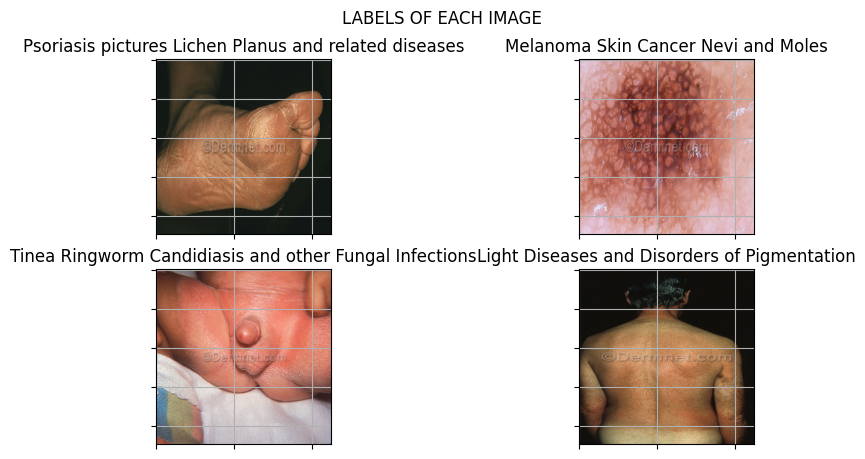

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
plt.suptitle('LABELS OF EACH IMAGE')

for (img, label), ax in zip(random.sample(train_data, 4), axes.flatten()):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True)
    ax.set_title(label)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )

plt.show()

In [6]:
class_names = sorted(os.listdir(data_path))
num_classes = len(class_names)

img_size = (224, 224, 3)

In [7]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=img_size)
base_model.trainable = False
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

80134624/80134624 [==============================] - 0s 0us/step


In [8]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
EPOCHS = 12
BATCH_SIZE = 32
history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot),
                   epochs = EPOCHS, batch_size=BATCH_SIZE)

model.save('/kaggle/working/VGG19.h5')

Epoch 1/12


I0000 00:00:1708923020.764638      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


138/138 [==============================] - 42s 225ms/step - loss: 3.0368 - accuracy: 0.2459 - val_loss: 1.8815 - val_accuracy: 0.4438
Epoch 2/12
138/138 [==============================] - 23s 166ms/step - loss: 1.8875 - accuracy: 0.4386 - val_loss: 1.4404 - val_accuracy: 0.5772
Epoch 3/12
138/138 [==============================] - 24s 172ms/step - loss: 1.4100 - accuracy: 0.5863 - val_loss: 1.0730 - val_accuracy: 0.7151
Epoch 4/12
138/138 [==============================] - 25s 183ms/step - loss: 1.0755 - accuracy: 0.6750 - val_loss: 0.8974 - val_accuracy: 0.7721
Epoch 5/12
138/138 [==============================] - 25s 181ms/step - loss: 0.8116 - accuracy: 0.7640 - val_loss: 0.6543 - val_accuracy: 0.8306
Epoch 6/12
138/138 [==============================] - 24s 176ms/step - loss: 0.6164 - accuracy: 0.8238 - val_loss: 0.5234 - val_accuracy: 0.8816
Epoch 7/12
138/138 [==============================] - 25s 179ms/step - loss: 0.4576 - accuracy: 0.8748 - val_loss: 0.4853 - val_accuracy: 0.8

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


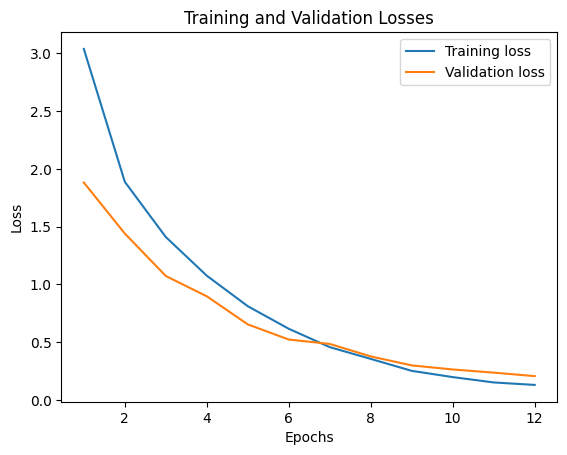

In [11]:
# Get the training and validation losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create an array representing the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation losses
plt.plot(epochs, train_loss,label='Training loss' )
plt.plot(epochs, val_loss,label='Validation loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

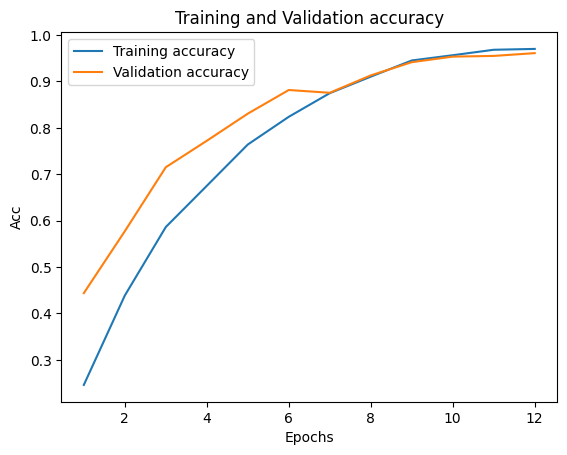

In [12]:
# Get the training and validation losses from the history object
train_loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

# Create an array representing the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation losses
plt.plot(epochs, train_loss,label='Training accuracy')
plt.plot(epochs, val_loss,label='Validation accuracy',)
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

# Show the plot
plt.show()

In [13]:
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/VGG19.h5') 
real_label = []
predicted_class = []

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        img = preprocess_input(np.array([img])) 

        predictions = model.predict(img)
        real_label.append(folder)
        predicted_class_index = np.argmax(predictions)
        predicted_class.append(le.classes_[predicted_class_index])

1/1 [==============================] - 0s 19ms/step


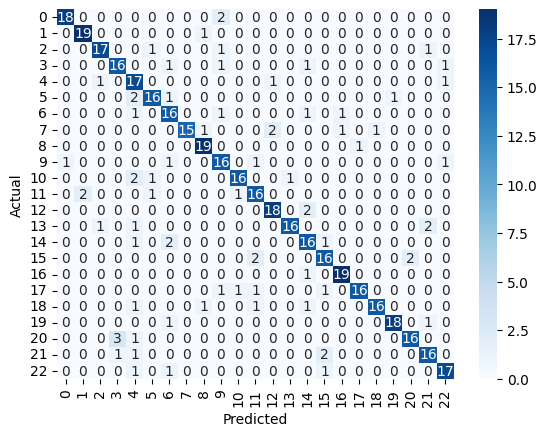

0.8369565217391305


In [14]:
from sklearn.metrics import confusion_matrix,accuracy_score
conf_matrix = confusion_matrix(real_label, predicted_class)
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(accuracy_score(real_label,predicted_class))

In [15]:
from sklearn.metrics import classification_report
print(classification_report(real_label, predicted_class))

                                                                    precision    recall  f1-score   support

                                                  Acne and Rosacea       0.95      0.90      0.92        20
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.90      0.95      0.93        20
                                                 Atopic Dermatitis       0.89      0.85      0.87        20
                                                   Bullous Disease       0.80      0.80      0.80        20
                Cellulitis Impetigo and other Bacterial Infections       0.61      0.85      0.71        20
                                                            Eczema       0.84      0.80      0.82        20
                                      Exanthems and Drug Eruptions       0.70      0.80      0.74        20
                 Hair Loss Photos Alopecia and other Hair Diseases       1.00      0.75      0.86        20
                           